In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('Software/stefan.mplstyle')

import pandas as pd
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'


# This notebook implements data quality cuts on the VAC catalog to get the catalog used for this analysis

In [2]:
#import the VAC catalog measurements
SDSSV=pd.read_csv('csv/SDSSV_DA_df.csv')
eSDSS=pd.read_csv('csv/eSDSS_DA_df.csv')

#drop duplicate observations since we will use only coadded measurements from individual WDs
SDSSV=SDSSV.drop_duplicates(subset='gaia_dr3_source_id')
#reset the indices
indices=np.arange(0,len(SDSSV))
SDSSV.set_index(indices,inplace=True)

eSDSS=eSDSS.drop_duplicates(subset='gaia_dr3_source_id')
#reset the indices
indices=np.arange(0,len(eSDSS))
eSDSS.set_index(indices,inplace=True)

In [19]:
dcut=30000

SDSSV_len=len(SDSSV.query('r_med_geo<@dcut'))
print(SDSSV_len)
print(len(SDSSV.query('phot_radius_sdss_med>0.015 and r_med_geo<@dcut')))
print(len(SDSSV.query('phot_radius_sdss_med>0.015 and r_med_geo<@dcut'))/SDSSV_len)
print(len(SDSSV.query('phot_radius_gaia_med>0.015 and r_med_geo<@dcut')))
print(len(SDSSV.query('phot_radius_gaia_med>0.015 and r_med_geo<@dcut'))/SDSSV_len)

print('')

eSDSS_len=len(eSDSS.query('r_med_geo<@dcut'))
print(eSDSS_len)
print(len(eSDSS.query('phot_radius_sdss_med>0.015 and r_med_geo<@dcut')))
print(len(eSDSS.query('phot_radius_sdss_med>0.015 and r_med_geo<@dcut'))/eSDSS_len)
print(len(eSDSS.query('phot_radius_gaia_med>0.015 and r_med_geo<@dcut')))
print(len(eSDSS.query('phot_radius_gaia_med>0.015 and r_med_geo<@dcut'))/eSDSS_len)

8545
1591
0.18619075482738442
2779
0.32521942656524283

19257
6917
0.35919405930311055
7168
0.37222828062522717


# Perform quality cuts

We only want objects with good spectra and photometry.

- SDSS coadd spectra SNR>10
    - For some of these objects, there may not be a corresponding weighted mean RV if no individual spectrum has a snr>10. This is why we prefer to use the coadded spectrum parameters
- Tremblay models are used to fit RVs and to fit phot teff/radius but these models only cover 1500<Teff<130,000K so remove any objects on the edge of the grid
    - Also restrict spectroscopic loggs/teffs to this range. The PRF routine can return measurements outside of this range but there is very very sparse training data in those regimes so those measurements should be considered unreliable and be excluded from this analysis
    - Take 1600<teff_phot<129,000 K and 1600<teff_prf_coadd<129,000 K
    - Take 7<logg_prf_coadd<9 dex
- e_rv_corv_coadd_full<50 km/s, make sure RV fit is decent
- E_Radius_Phot_full<$0.006$ Rsun, make sure radius fit is decent
- E_Logg_prf_coadd_full<$0.3$ dex, make sure logg fit is decent
- Binary_flag=0 to remove objects flagged as potential binaries
- Bailer-Jones distance r_med_geo<1000 pc
    - WD count REALLY drops off after this distance, and we want to have enough WDs at any given separation

In [4]:
print('total number independent objects=',len(SDSSV))
print('')

#show effect of snr cut
SDSSV_cut=SDSSV.query('snr_coadd>10')
print('cut on snr_coadd')
print('number independent objects=',len(SDSSV_cut))
print('')

SDSSV_cut=SDSSV_cut.query('7<logg_prf_coadd<9 and 1600<teff_phot<129000 and 1600<teff_prf_coadd<129000 and e_radius_phot_full<0.006 and e_logg_prf_coadd_full<0.3')
print('cut on logg, teff, radius error, and logg error')
print('number independent objects=',len(SDSSV_cut))
print('')

SDSSV_cut=SDSSV_cut.query('binary_flag==0')
print('remove flagged binaries')
print('number independent objects=',len(SDSSV_cut))


total number independent objects= 8545

cut on snr_coadd
number independent objects= 3772

cut on logg, teff, radius error, and logg error
number independent objects= 3141

remove flagged binaries
number independent objects= 3009


In [5]:
print('total number independent objects=',len(eSDSS))
print('')

#show effect of snr cut
eSDSS_cut=eSDSS.query('snr_coadd>10')
print('cut on snr_coadd')
print('number independent objects=',len(eSDSS_cut))
print('')

#eSDSS_cut=eSDSS_cut.query('7<logg_prf_coadd<9 and 1600<teff_phot<129000 and 1600<teff_prf_coadd<129000 and e_rv_corv_coadd_full<50 and e_radius_phot_full<0.006 and e_logg_prf_coadd_full<0.3')
#print('cut on logg, teff, RV error, radius error, and logg error')

eSDSS_cut=eSDSS_cut.query('7<logg_prf_coadd<9 and 1600<teff_phot<129000 and 1600<teff_prf_coadd<129000 and e_radius_phot_full<0.006 and e_logg_prf_coadd_full<0.3')
print('cut on logg, teff, radius error, and logg error')
print('number independent objects=',len(eSDSS_cut))
print('')

eSDSS_cut=eSDSS_cut.query('binary_flag==0')
print('remove flagged binaries')
print('number independent objects=',len(eSDSS_cut))



total number independent objects= 19257

cut on snr_coadd
number independent objects= 9677

cut on logg, teff, radius error, and logg error
number independent objects= 8193

remove flagged binaries
number independent objects= 7925


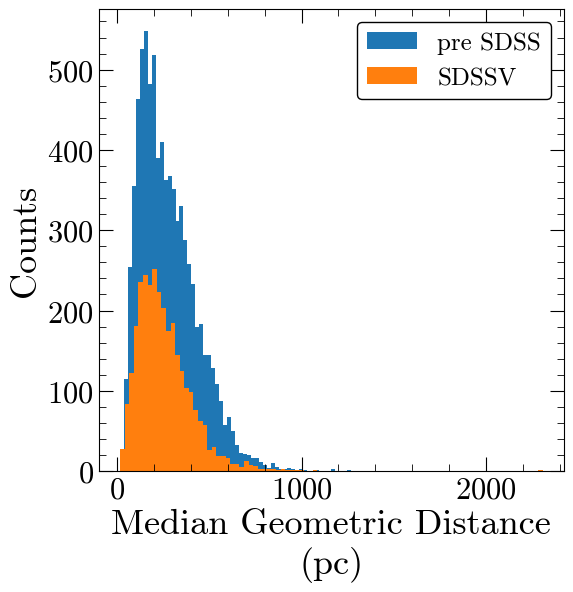

In [6]:
fig, ax1 = plt.subplots(1,1,figsize=(6,6))
ax1.hist(eSDSS_cut['r_med_geo'],label='pre SDSS')
ax1.hist(SDSSV_cut['r_med_geo'],label='SDSSV')
ax1.legend()
ax1.set_xlabel('Median Geometric Distance\n(pc)')
ax1.set_ylabel('Counts')
plt.show()

In [7]:
#show effect of distance cut
SDSSV_cut=SDSSV_cut.query('r_med_geo<1000')
print('cut on r_med_geo')
print('number independent objects=',len(SDSSV_cut))
print('')

#show effect of distance cut
eSDSS_cut=eSDSS_cut.query('r_med_geo<1000')
print('cut on r_med_geo')
print('number independent objects=',len(eSDSS_cut))


cut on r_med_geo
number independent objects= 3006

cut on r_med_geo
number independent objects= 7918


# Combine the SDSS-V and eSDSS tables

In [8]:
#combine the two tables, for any object in both tables, 
#take the weighted mean of the SDSS-V and eSDSS measurements

#add flag for whether object is SDSS-V or early SDSS
SDSSV_cut['sdssv_flag']=np.full(len(SDSSV_cut),True)
eSDSS_cut['sdssv_flag']=np.full(len(eSDSS_cut),False)

#combine the data sets
#wd_table=SDSSV_cut.append(eSDSS_cut)
wd_table=pd.concat([SDSSV_cut, eSDSS_cut], ignore_index=True)  
#reset the indices
indices=np.arange(0,len(wd_table))
wd_table.set_index(indices,inplace=True)

In [9]:
def weighted_mean(x,e_x,df):
    x_list=np.array(df[x].to_list())
    e_x_list=np.array(df[e_x].to_list())
    #calculate weights
    x_weights=(1/e_x_list)**2
    #calculate mean x and error on mean
    mean_x=np.average(x_list,weights=x_weights)
    e_mean_x=1/np.sqrt(np.sum(x_weights))
    return(mean_x,e_mean_x)

In [10]:
overlap_mask=wd_table.duplicated(subset=['gaia_dr3_source_id'])
overlap=wd_table[overlap_mask]
overlap_ids=overlap['gaia_dr3_source_id'].unique()
for gaia_id in overlap_ids:
    tmp=wd_table.query('gaia_dr3_source_id==@gaia_id')
    
    #get weighted mean parameters
    mean_rv_corv_coadd,e_mean_rv_corv_coadd=weighted_mean('rv_corv_coadd','e_rv_corv_coadd_full',tmp)
    mean_teff_prf_coadd,e_mean_teff_prf_coadd=weighted_mean('teff_prf_coadd','e_teff_prf_coadd_full',tmp)
    mean_logg_prf_coadd,e_mean_logg_prf_coadd=weighted_mean('logg_prf_coadd','e_logg_prf_coadd_full',tmp)
    mean_radius_phot,e_mean_radius_phot=weighted_mean('radius_phot','e_radius_phot_full',tmp)
    mean_teff_phot,e_mean_teff_phot=weighted_mean('teff_phot','e_teff_phot_full',tmp)
    mean_mass_rad_logg,e_mean_mass_rad_logg=weighted_mean('mass_rad_logg','e_mass_rad_logg',tmp)
    mean_mass_logg_theory,e_mean_mass_logg_theory=weighted_mean('mass_logg_theory','e_mass_logg_theory',tmp)
    mean_mass_rad_theory,e_mean_mass_rad_theory=weighted_mean('mass_rad_theory','e_mass_rad_theory',tmp)
    
    #update combined sample to have weigthed mean parameters
    ind=tmp.index
    wd_table['rv_corv_coadd'].loc[ind]=mean_rv_corv_coadd
    wd_table['e_rv_corv_coadd_full'].loc[ind]=e_mean_rv_corv_coadd
    wd_table['teff_prf_coadd'].loc[ind]=mean_teff_prf_coadd
    wd_table['e_teff_prf_coadd_full'].loc[ind]=e_mean_teff_prf_coadd
    wd_table['logg_prf_coadd'].loc[ind]=mean_logg_prf_coadd
    wd_table['e_logg_prf_coadd_full'].loc[ind]=e_mean_logg_prf_coadd
    wd_table['radius_phot'].loc[ind]=mean_radius_phot
    wd_table['e_radius_phot_full'].loc[ind]=e_mean_radius_phot
    wd_table['teff_phot'].loc[ind]=mean_teff_phot
    wd_table['e_teff_phot_full'].loc[ind]=e_mean_teff_phot
    wd_table['mass_rad_logg'].loc[ind]=mean_mass_rad_logg
    wd_table['e_mass_rad_logg'].loc[ind]=e_mean_mass_rad_logg
    wd_table['mass_logg_theory'].loc[ind]=mean_mass_logg_theory
    wd_table['e_mass_logg_theory'].loc[ind]=e_mean_mass_logg_theory
    wd_table['mass_rad_theory'].loc[ind]=mean_mass_rad_theory
    wd_table['e_mass_rad_theory'].loc[ind]=e_mean_mass_rad_theory


In [11]:
#drop duplicate gaia_dr3_source_ids
print(len(wd_table))
wd_table=wd_table.drop_duplicates(subset='gaia_dr3_source_id')
print(len(wd_table))
#reset the indices
indices=np.arange(0,len(wd_table))
wd_table.set_index(indices,inplace=True)


10924
10207


# Final Sample Size=10,207 DA WDs
Save the table

In [12]:
wd_table.to_csv('csv/wd_table.csv',index=False)

# Repeat for all WDs to come up with realistic maximum number of WD observations
The constraining power of this method increases a lot with number of objects available. Right now, many WDs are being cut due to poor SNR, but follow-up observations could easily make these objects useful in this technique. For our simulations, we want to characterize the constraining power for our current data set of 10,538 well-observed WDs. In addition, we want to characterize how well future observations could constrain this effect.
- Cut only on distance and binaries, still keep distance cut=1000 pc

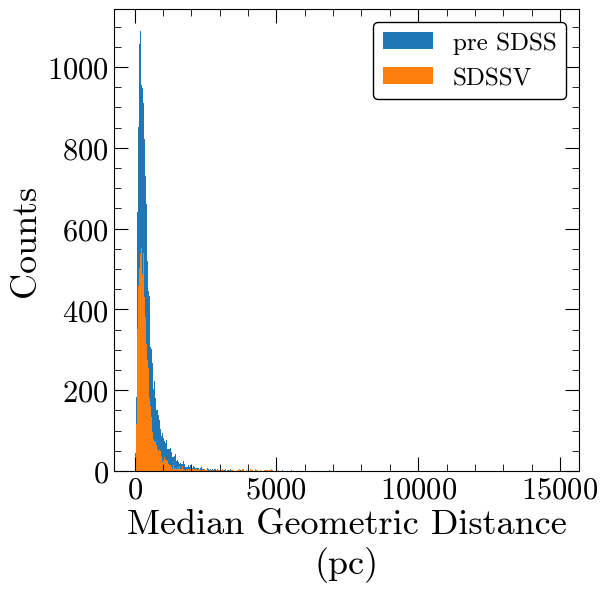

In [13]:
fig, ax1 = plt.subplots(1,1,figsize=(6,6))
ax1.hist(eSDSS['r_med_geo'],label='pre SDSS')
ax1.hist(SDSSV['r_med_geo'],label='SDSSV')
ax1.legend()
ax1.set_xlabel('Median Geometric Distance\n(pc)')
ax1.set_ylabel('Counts')
plt.show()

In [14]:
#show effect of distance cut
print('number independent objects=',len(SDSSV))
SDSSV_cut2=SDSSV.query('r_med_geo<1000 and binary_flag==0')
print('cut on r_med_geo and binaries')
print('number independent objects=',len(SDSSV_cut2))
print('')

#show effect of distance cut
print('number independent objects=',len(eSDSS))
eSDSS_cut2=eSDSS.query('r_med_geo<1000 and binary_flag==0')
print('cut on r_med_geo and binaries')
print('number independent objects=',len(eSDSS_cut2))


number independent objects= 8545
cut on r_med_geo and binaries
number independent objects= 7719

number independent objects= 19257
cut on r_med_geo and binaries
number independent objects= 17189


In [15]:
#combine the two tables

#combine the data sets
#wd_table2=SDSSV_cut2.append(eSDSS_cut2)
wd_table2=pd.concat([SDSSV_cut2, eSDSS_cut2], ignore_index=True)  
#drop duplicate gaia_dr3_source_ids
print(len(wd_table2))
wd_table2=wd_table2.drop_duplicates(subset='gaia_dr3_source_id')
print(len(wd_table2))


24908
23322


# Realistic sample size within 1000pc with better observations = 23,322 DA WDs